In [1]:
from scipy.io import arff
import numpy as np
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer
from collections import defaultdict
from scipy.stats import rankdata
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
class surrogate:

    def __init__(self, ntrees=16):
        self.models = {}
        self.ntrees = ntrees

    def get_data(self, data, relevant_params):
        task_ids = data["task_id"].unique()
        data = data[relevant_params + ["task_id"] + ["y"]]
        self.data_dict = defaultdict()
        for task_id in task_ids:
            X_task = data.loc[data["task_id"] == task_id]
            y_task = np.array(X_task["y"], dtype=np.float)
            X_task.drop(["y", "task_id"], 1, inplace=True)
            categorical_names = X_task.select_dtypes(include=['object']).columns
            categorical_ids = [X_task.columns.get_loc(colname) for colname in categorical_names]
            self.data_dict[task_id] = (X_task.as_matrix(), y_task, categorical_ids)
        return task_ids

    def split_data(self, X, y, test_size = 0.15, seed = 42):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        return X_train, X_test, y_train, y_test

    def train_model(self, X, y, categoricals, task_id):
        if task_id in self.models:
            return self.models[task_id]
        clf = Pipeline(
            steps=[('encoder', sklearn.preprocessing.OneHotEncoder(
                categorical_features=list(categoricals), handle_unknown='ignore')),
                    ('classifier', RandomForestRegressor(n_estimators=self.ntrees))])
        clf.fit(X, y)
        self.models[task_id] = clf
        return clf

    def average_rank(self, val_task_id):
        X_val, y_val, cat_val = self.data_dict[val_task_id]
        total_ranks = np.zeros(len(X_val))
        for task_id in self.data_dict:
            if task_id == val_task_id:
                continue
            X_train, y_train, cat_train = self.data_dict[task_id]
            clf = self.train_model(X_train, y_train, cat_train, task_id)
            y_val_hat = clf.predict(X_val)
            task_ranks = rankdata(y_val_hat, method='average')
            total_ranks = np.add(total_ranks, task_ranks)
        total_ranks = np.divide(total_ranks, len(X_val))
        return total_ranks

    def custom_scorer(self, y, y_hat):
        return pearsonr(y, y_hat)[0]

    def train_surrogate(self, filename="libsvm_svc.arff", relevant_params=["C", "gamma"]):
        data, meta = arff.loadarff(filename)
        df = pd.DataFrame(data)
        #print("Printing sample data")
        #print(df[:5])
        #print("Data info")
        #print(meta)
        task_ids = self.get_data(df, relevant_params)
        pearson_scores = []
        for task_id in task_ids:
            X, y, categoricals = self.data_dict[task_id]
            clf = self.train_model(X, y, categoricals, task_id)
            y_hat = cross_val_predict(clf, X, y, cv=5)
            score = pearsonr(y, y_hat)[0]
            pearson_scores.append(score)
            # scores = cross_val_score(clf, X, y, cv=5, scoring=make_scorer(self.custom_scorer))
            # mean_score = scores.mean()
            # spearman = pearsonr(y, y_hat)
            # pearson_scores.append(mean_score)
            # print("Task %d; Pearson Spearman Correlation: %0.4f (+/- %0.4f)" %(task_id, mean_score, scores.std() * 2))
            average_rank = self.average_rank(task_id)
            ar_spearman = pearsonr(y, average_rank)
            # print("Task %d; Average Rank: Pearson Spearman Correlation: %f" % (task_id, ar_spearman[0]))
        return pearson_scores


In [3]:
s = surrogate()
surrogate_scores = s.train_surrogate()

/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/Users/prernakashyap/anaconda3/envs/gensim_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [4]:
# y = alpha * hyperparameter_1 ^ 2 + beta * hyperparameter_2 ^ 2 + gamma * hyperparameter_1 * hyperparameter_2 + delta
# hyperparameter_1 = gamma
# hyperparameter_2 = complexity (C)
class simplified_surrogate:

    def __init__(self, surrogate):
        self.surrogate = surrogate
        self.models = {}

    def train_model(self):
        pearson_scores = []
        for task_id in self.surrogate.data_dict:
            X, y, _ = self.surrogate.data_dict[task_id]
            X = np.append(X ** 2, np.ones(X.shape), axis = 1)
            model = LinearRegression()
            model.fit(X, y)
            # coeff = model.coef_
            self.models[task_id] = model
            y_hat = cross_val_predict(model, X, y, cv=5)
            score = pearsonr(y, y_hat)[0]
            # score = pearsonr(y, model.predict(X))[0]
            pearson_scores.append(score)
            # print("Task %d; Pearson Spearman Correlation: %f" % (task_id, score))
        return pearson_scores

    def plot_curve(self, task_id):
        X, y, _ = self.surrogate.data_dict[task_id]
        model = self.models[task_id]
        y_hat = model.predict(np.append(X, X ** 2, axis = 1))
        plt.plot(y_hat, c="blue")
        plt.plot(y, c="red")
        plt.axis("equal")

In [5]:
s_ = simplified_surrogate(s)
simplified_surrogate_scores = s_.train_model()

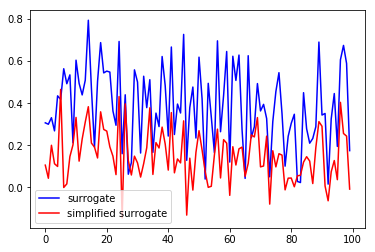

In [6]:
plt.plot(surrogate_scores, color="blue", label="surrogate")
plt.plot(simplified_surrogate_scores, color="red", label="simplified surrogate")
plt.legend()
plt.show()

In [7]:
def draw_plot(data, offset,edge_color, fill_color):
    pos = np.arange(1) + offset 
    bp = ax.boxplot(data, positions= pos, widths=0.3, patch_artist=True, manage_xticks=False)
    for element in ['boxes', 'whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

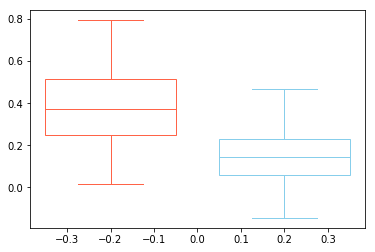

In [8]:
fig, ax = plt.subplots()
draw_plot(surrogate_scores, -0.2, "tomato", "white")
draw_plot(simplified_surrogate_scores, +0.2, "skyblue", "white")
plt.show()
plt.close()

TODO<br>
-> tune RF hyperparameters (no. of trees, no. of features per node)<br>
-> use random search for <br>
-> sklearnbot openml - generating more data<br>
-> Bernd Bischl, Carlos Soares<br>
-> Expected median (~0.5-0.6)<br>